## Example -- IEA Wind 740-10-MW

**IEA Wind TCP Task 55: The IEA Wind 740-10-MW Reference Offshore Wind Plants**

<https://www.osti.gov/biblio/2333634/>

This notebook uses `optiwindnet` to route the collector system cables for the two wind power plants presented in the report above.

In [29]:
import numpy as np
from optiwindnet.api import WindFarmNetwork, MetaHeuristic, MILP, ModelOptions

In [ ]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

### Cable data

In [30]:
cable_costs = [206, 287, 406]  # [€/m] Costs per distance for each cable type
turbines_per_cable = [3, 5, 7]
cables = [(capacity, cost) for capacity, cost in zip(turbines_per_cable, cable_costs)]

### Load layouts from files (Regular and Irregular layouts)

`WinfFarmNetwork.from_windIO()`is specifically introduced for WindIO file formats.

In [31]:
wfn_reg = WindFarmNetwork.from_windIO(filepath='data/IEA37_Borssele_Regular_System.yaml', cables=cables)

In [32]:
wfn_irr = WindFarmNetwork.from_windIO(filepath='data/IEA37_Borssele_Irregular_System.yaml', cables=cables)

### Plot locations

<Axes: >

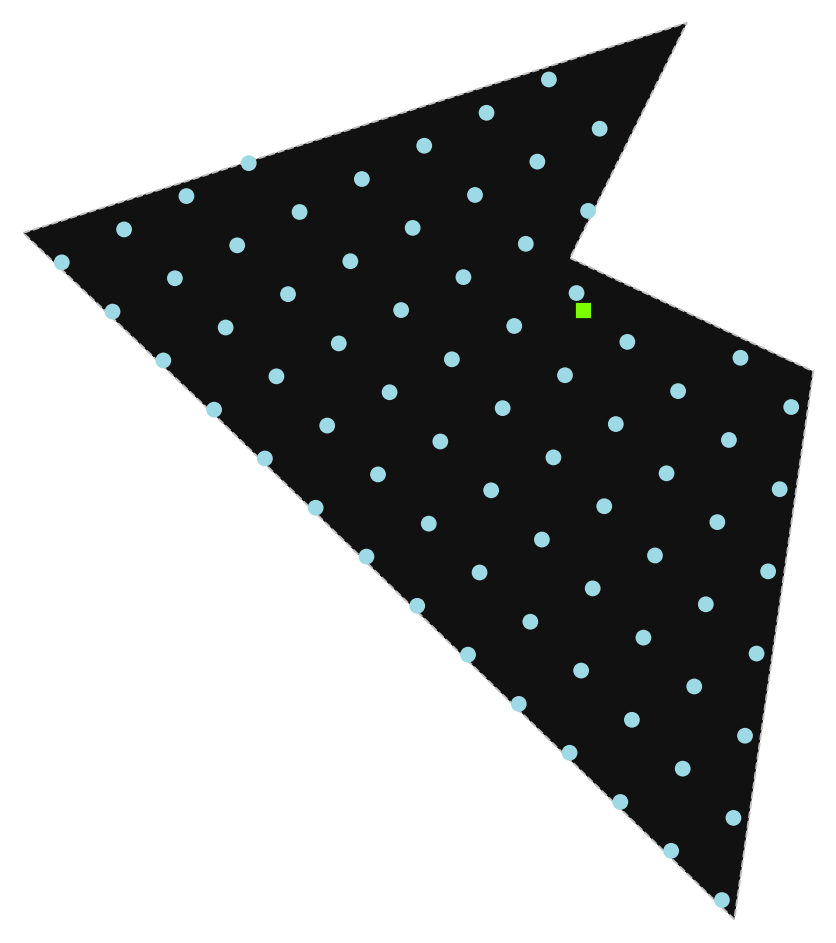

In [33]:
wfn_reg.plot_location()

<Axes: >

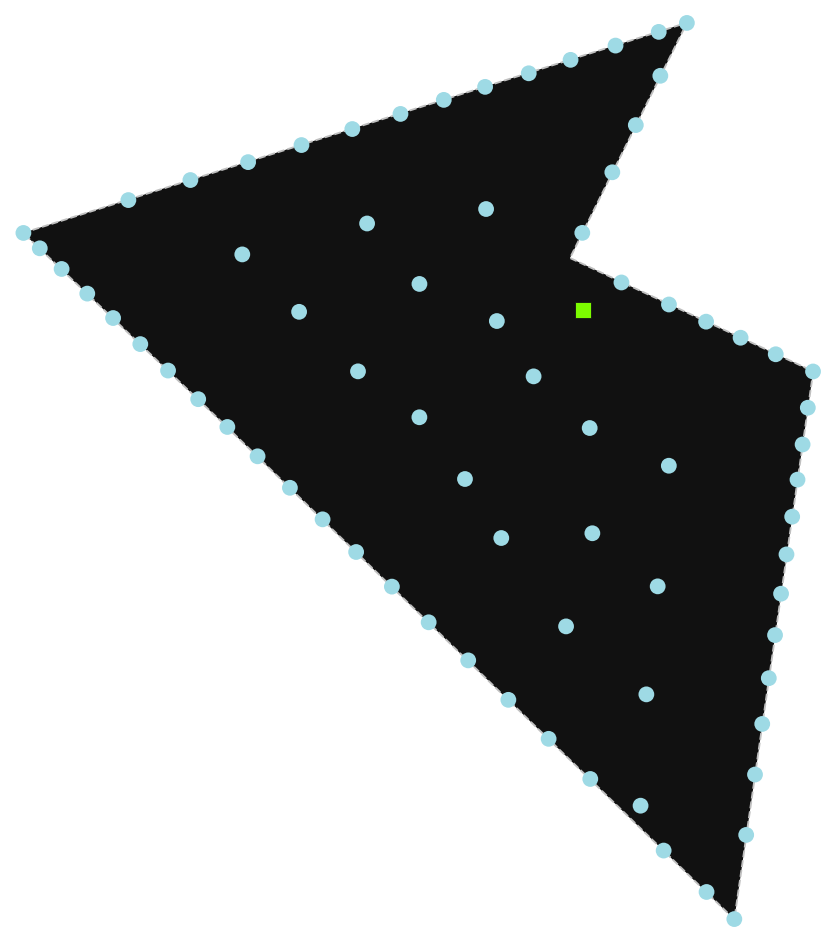

In [34]:
wfn_irr.plot_location()

### Choose the OR-Tools CP-Sat solver

In [35]:
router_warmstart = MetaHeuristic(time_limit=1, verbose=True)

solver_options=dict(
        num_workers = 8,
    )

model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )
router_main = MILP(solver_name='ortools', time_limit=5, mip_gap=0.005, solver_options=solver_options, model_options=model_options, verbose=True)

### Regular layout

In [36]:
res_reg_warmup = wfn_reg.optimize(router=router_warmstart)

In [37]:
wfn_reg.S

Check the total length of the warm-start solution:

In [38]:
wfn_reg.length()

139656.47984275874

Optimize with main router

In [39]:
router_main.solver.solver.log_callback = print

In [40]:
res_reg = wfn_reg.optimize(router=router_main, verbose=True)


Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 5 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model '': (model_fingerprint: 0x86b6da438a16703b)
#Variables: 1'540 (#bools: 770 in floating point objective)
  - 770 Booleans in [0,1]
  - 696 in [0,6]
  - 74 in [0,7]
#kAtMostOne: 615 (#literals: 1'926)
#kLinear1: 1'540 (#enforced: 1'540)
#kLinear3: 2
#kLinearN: 223 (#terms: 3'844)

Starting presolve at 0.01s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 770 terms with magnitude in [440.736, 14559.3] average = 2880.02
[Scaling] Objective coefficient relative error: 6.70633e-10
[Scaling] Objective worst-case absolute error: 7.704e-05
[Scaling] Objective scaling factor: 1.04858e+06
  8.00e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.61e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  1.39e-04s  0.00e+00d  [operat

In [41]:
wfn_reg.length()

139645.18265364

In [42]:
wfn_reg.cost()

40714260.58298516

<Axes: >

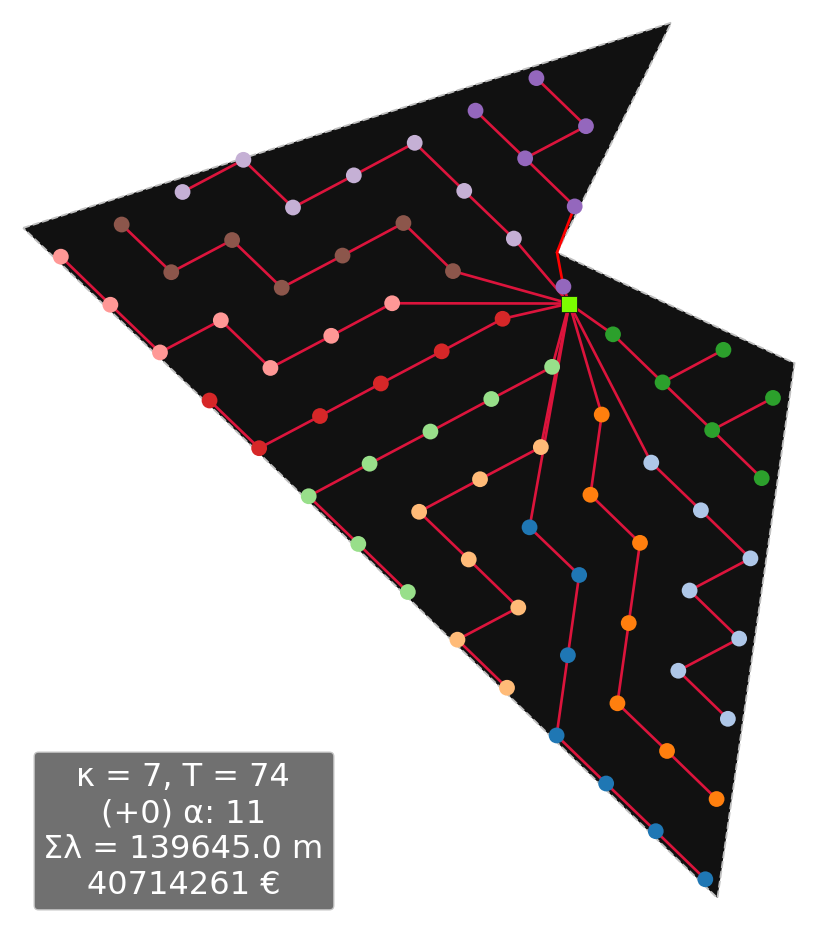

In [43]:
wfn_reg.plot()

### Irregular layout

In [44]:
res_irr_warmup = wfn_irr.optimize(router=router_warmstart)

Check the total length of the warm-start solution:

In [45]:
wfn_irr.length()

136793.6675287013

Optimize with main router

In [46]:
res_irr = wfn_irr.optimize(router=router_main)


Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 5 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model '': (model_fingerprint: 0xf17fca903019497a)
#Variables: 1'192 (#bools: 596 in floating point objective)
  - 596 Booleans in [0,1]
  - 522 in [0,6]
  - 74 in [0,7]
#kAtMostOne: 419 (#literals: 1'216)
#kLinear1: 1'192 (#enforced: 1'192)
#kLinear2: 4
#kLinear3: 5
#kLinearN: 216 (#terms: 2'957)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 596 terms with magnitude in [539.378, 15073.7] average = 3460.13
[Scaling] Objective coefficient relative error: 4.51281e-10
[Scaling] Objective worst-case absolute error: 7.28067e-05
[Scaling] Objective scaling factor: 1.04858e+06
  4.10e-04s  0.00e+00d  [DetectDominanceRelations] 
  7.69e-03s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  6.10e-05s  0.0

In [47]:
wfn_irr.length()

136339.92556927513

In [48]:
wfn_irr.cost()

42959686.97419984

<Axes: >

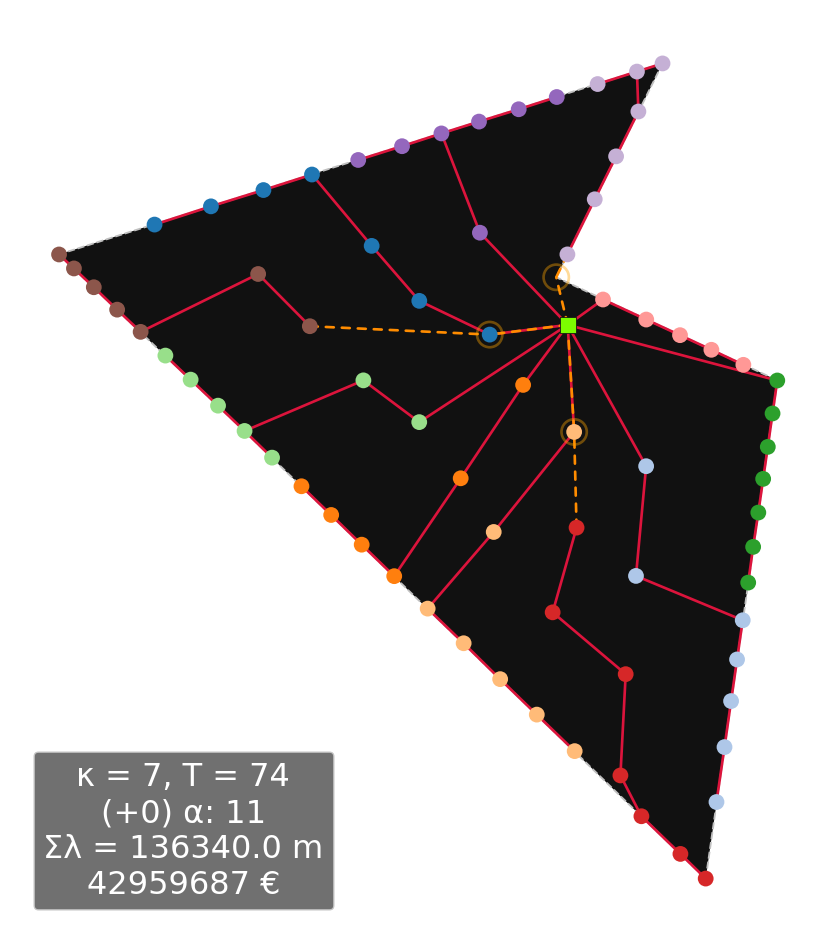

In [49]:
wfn_irr.plot()

### Layouts' edge list

These lists of 3-tuples has all the edges and their cable type (as an index to the `turbines_per_cable` list), i.e. (coordinate_A, coordinate_B, cable_type).

Negative node indices represent substations, the node indices ranging from 0 to 73 represent the WT in the order they were given.

If the layout has contours or detours, indices will go beyond the number of coordinates (WT, SS, borders) provided, and the mapping of these additional indices to indices to the provided coordinates is presented.

In [50]:
wfn_reg.G.edges(data='cable')

EdgeDataView([(72, 71, 0), (73, 66, 0), (67, 57, 2), (67, 68, 1), (68, 69, 1), (45, -1, 2), (45, 44, 1), (65, 66, 1), (65, 80, 1), (18, 19, 0), (26, 17, 1), (26, 25, 1), (44, 31, 0), (44, 43, 0), (33, -1, 2), (33, 23, 2), (70, 61, 0), (70, 63, 0), (61, 69, 0), (5, 4, 0), (5, 9, 1), (10, 11, 0), (51, 62, 0), (51, 60, 1), (62, 53, 0), (8, 14, 0), (8, 3, 0), (9, 15, 1), (40, 29, 0), (41, 52, 0), (41, 54, 0), (14, 22, 1), (22, 23, 1), (39, 52, 1), (39, 50, 1), (34, 25, 2), (34, -1, 2), (57, -1, 2), (66, 71, 0), (53, 64, 0), (15, 24, 2), (19, 28, 0), (3, 2, 0), (6, 7, 0), (11, 16, 0), (16, 17, 0), (-1, 56, 2), (-1, 47, 2), (-1, 46, 2), (-1, 24, 2), (-1, 58, 2), (-1, 32, 2), (-1, 49, 2), (46, 35, 2), (27, 28, 0), (27, 36, 1), (36, 35, 1), (48, 37, 1), (48, 47, 1), (7, 12, 0), (12, 13, 0), (42, 31, 0), (59, 58, 2), (59, 60, 1), (38, 29, 0), (38, 37, 0), (20, 13, 1), (20, 21, 1), (49, 50, 2), (21, 32, 2), (31, 30, 0), (0, 1, 0), (1, 4, 0), (56, 80, 1), (54, 55, 0)])

Alternatively we can use `get_network()` method, to get the final cabling network as a structured array of edge data, and then extract desired edge data from it.

Regular layout

In [51]:
network_reg = wfn_reg.get_network()
print(network_reg.dtype.names)

('src', 'tgt', 'length', 'load', 'reverse', 'cable', 'cost')


In [52]:
network_cable_reg = np.column_stack((network_reg['src'], network_reg['tgt'], network_reg['cable']))
print(network_cable_reg)


[[72 71  0]
 [73 66  0]
 [67 57  2]
 [67 68  1]
 [68 69  1]
 [45 -1  2]
 [45 44  1]
 [65 66  1]
 [65 80  1]
 [18 19  0]
 [26 17  1]
 [26 25  1]
 [44 31  0]
 [44 43  0]
 [33 -1  2]
 [33 23  2]
 [70 61  0]
 [70 63  0]
 [61 69  0]
 [ 5  4  0]
 [ 5  9  1]
 [10 11  0]
 [51 62  0]
 [51 60  1]
 [62 53  0]
 [ 8 14  0]
 [ 8  3  0]
 [ 9 15  1]
 [40 29  0]
 [41 52  0]
 [41 54  0]
 [14 22  1]
 [22 23  1]
 [39 52  1]
 [39 50  1]
 [34 25  2]
 [34 -1  2]
 [57 -1  2]
 [66 71  0]
 [53 64  0]
 [15 24  2]
 [19 28  0]
 [ 3  2  0]
 [ 6  7  0]
 [11 16  0]
 [16 17  0]
 [-1 56  2]
 [-1 47  2]
 [-1 46  2]
 [-1 24  2]
 [-1 58  2]
 [-1 32  2]
 [-1 49  2]
 [46 35  2]
 [27 28  0]
 [27 36  1]
 [36 35  1]
 [48 37  1]
 [48 47  1]
 [ 7 12  0]
 [12 13  0]
 [42 31  0]
 [59 58  2]
 [59 60  1]
 [38 29  0]
 [38 37  0]
 [20 13  1]
 [20 21  1]
 [49 50  2]
 [21 32  2]
 [31 30  0]
 [ 0  1  0]
 [ 1  4  0]
 [56 80  1]
 [54 55  0]]


Irregular layout

In [53]:
network_irr = wfn_irr.get_network()
network_cable_irr = np.column_stack((network_irr['src'], network_irr['tgt'], network_irr['cable']))
print(network_cable_irr)

[[15 21  0]
 [15  3  0]
 [21 66  0]
 [58 65  0]
 [58 61  1]
 [65 48  0]
 [65 47  0]
 [16 29  1]
 [16 17  0]
 [29 53  1]
 [36 62  0]
 [36 35  0]
 [62 63  1]
 [42  8  2]
 [42 -1  2]
 [37 67  1]
 [37 51  2]
 [70 33  2]
 [70 12  1]
 [ 5  9  0]
 [ 5 32  0]
 [10 24  0]
 [40 55  1]
 [40 57  0]
 [41 -1  2]
 [41 69  2]
 [34  1  1]
 [34 20  0]
 [49 54  2]
 [49 -1  2]
 [53 28  2]
 [46 50  0]
 [46 44  0]
 [22  4  0]
 [44 67  1]
 [23 43  0]
 [23 45  0]
 [43  7  0]
 [31 26  0]
 [31 56  0]
 [56 30  0]
 [56 54  1]
 [68 14  1]
 [68 73  2]
 [13 26  0]
 [-1 60  2]
 [-1 55  1]
 [-1 39  2]
 [-1 28  2]
 [-1 33  2]
 [-1 80  2]
 [-1 81  2]
 [-1 82  2]
 [71 64  2]
 [71 82  2]
 [64 61  1]
 [51 80  2]
 [27 52  0]
 [27 38  0]
 [52 59  0]
 [60 59  2]
 [ 3 12  1]
 [50  0  0]
 [ 9 19  0]
 [11 18  0]
 [ 2  8  1]
 [ 2  7  1]
 [25 72  0]
 [73 81  2]
 [69  1  1]
 [57 72  0]
 [39 63  1]
 [32 14  1]
 [18 59  0]
 [17 24  0]
 [ 6 35  0]
 [20  4  0]]


Mapping of contour/detour node to the index of its VertexC coordinate :

In [54]:
if wfn_reg.G.graph.get('C') or wfn_reg.G.graph.get('D'):
    R, T, B = (wfn_reg.G.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in wfn_reg.G.graph['fnT'][T + B:-R]),
        start=T + B
    )))

{80: 76}


Mapping of contour/detour node to the index of its VertexC coordinate :

In [55]:
if wfn_irr.G.graph.get('C') or wfn_irr.G.graph.get('D'):
    R, T, B = (wfn_irr.G.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in wfn_irr.G.graph['fnT'][T + B:-R]),
        start=T + B
    )))

{80: 41, 81: 28, 82: 76}
